Number of fraudulent transactions: 7506
Number of non-fraudulent transactions: 1289169


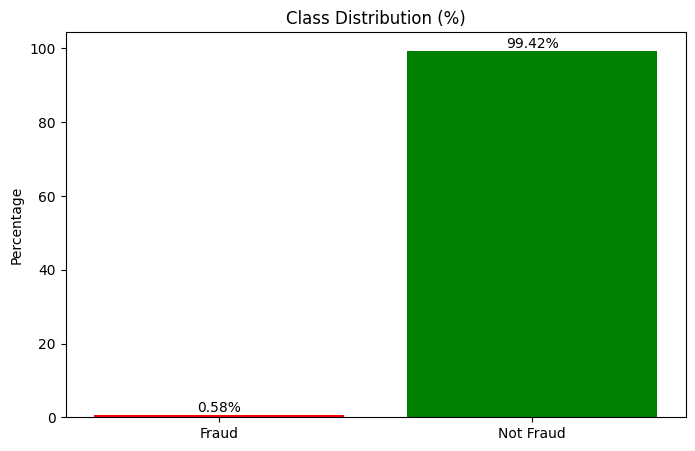

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

path = '../data/raw/fraudTrain.csv'
df = pd.read_csv(path, index_col=0)

is_fraud = 0
is_not_fraud = 0

for col in df['is_fraud']:
    if col == 1:
        is_fraud += 1
    else:
        is_not_fraud += 1


print(f"Number of fraudulent transactions: {is_fraud}")
print(f"Number of non-fraudulent transactions: {is_not_fraud}")

labels = ['Fraud', 'Not Fraud']
values = [is_fraud, is_not_fraud]
total = is_fraud + is_not_fraud

fraud_percentage = (is_fraud / total) * 100
not_fraud_percentage = (is_not_fraud / total) * 100

labels = ['Fraud', 'Not Fraud']
values = [fraud_percentage, not_fraud_percentage]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, values, color=['red', 'green'])

plt.title('Class Distribution (%)')
plt.ylabel('Percentage')

for bar, value in zip(bars, values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f'{value:.2f}%',
        ha='center',
        va='bottom'
    )

plt.show()



Observemos que la cantidad de trasacciones fraudulentas son muy insignificante al lado de las trasancciones normales. Por lo tanto el dataset esta altamente desbalanceado. Esto quiere decir que no podemos realizar un modelo simple que indique si tenemos una trasacciones fraudulenta o no, ya que siempre va predecir que no lo es, lo cual nos llevaria a tener un modelo inutil, sin practicamente informacion de la cual aprender.


Aca entra SMOTE (Synthetic Minority Over-sampling Technique):

¿Qué hace? En lugar de simplemente duplicar las filas de fraude existentes, SMOTE mira los puntos de fraude en el espacio multidimensional y crea nuevos puntos sintéticos en el medio de ellos.

Resultado: Inventa datos de fraude "verosímiles" para que tu modelo de Sklearn (como un Random Forest) tenga suficientes ejemplos para aprender los patrones del robo.

In [3]:
#Drop list of columns with redundant information

columns_to_drop = ['trans_num','cc_num','first', 'last', 'street', 'unix_time']
try:
    df_processed = df.drop(columns=columns_to_drop)
    print("Successfully dropped columns")

    df_processed.to_csv('../data/processed/fraudTrainProcessed.csv', index=False)
    print("Successfully created CSV file")
except KeyError as e:
    print(f"Error: Column {e} not found in DataFrame.")
except Exception as e:
    print(f"Error processing DataFrame: {e}")

Successfully dropped columns


Successfully created CSV file


Transaction date successfully converted to datetime format


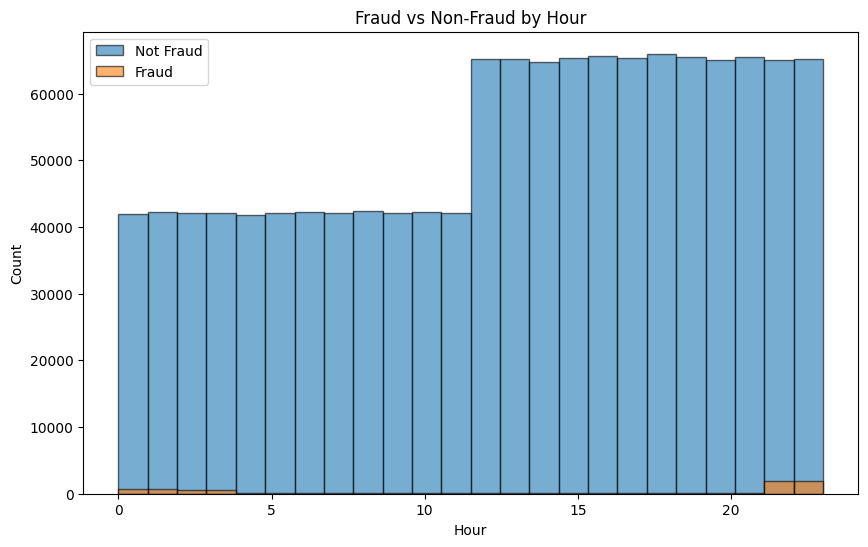

In [4]:
#Transform in datetime format
try:
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
    print("Transaction date successfully converted to datetime format") 

    df['hour'] = df['trans_date_trans_time'].dt.hour

# Analyze the distribution of fraudulent vs non-fraudulent transactions by hour

    fraud = df[df['is_fraud'] == 1]
    not_fraud = df[df['is_fraud'] == 0]

    plt.figure(figsize=(10,6))

    plt.hist(not_fraud['hour'], bins=24, alpha=0.6, label='Not Fraud', edgecolor='black')
    plt.hist(fraud['hour'], bins=24, alpha=0.6, label='Fraud', edgecolor='black')

    plt.legend()
    plt.xlabel('Hour')
    plt.ylabel('Count')
    plt.title('Fraud vs Non-Fraud by Hour')

    plt.show()

except Exception as e:
    print(f"Error processing transaction date: {e}")
except KeyError as e:
    print(f"Error: Column {e} not found in DataFrame.")

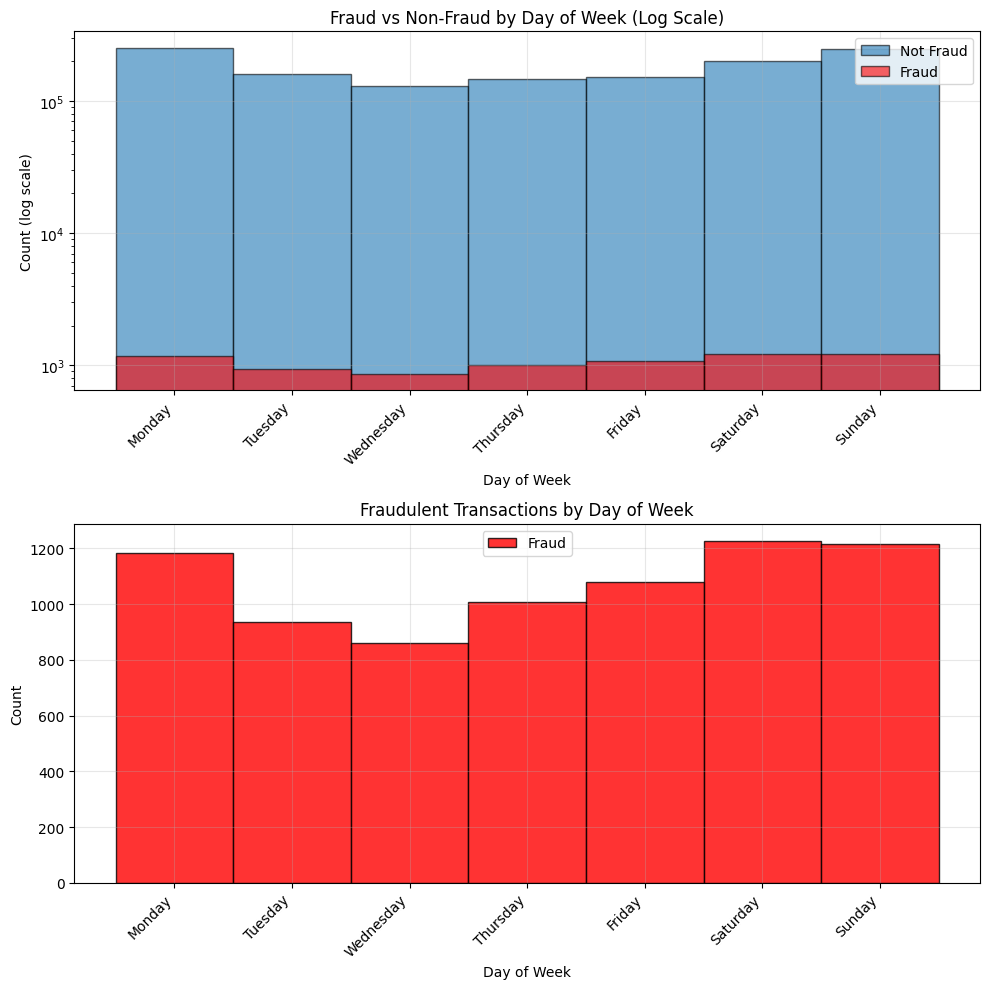

In [5]:
# Analyze the distribution of fraudulent vs non-fraudulent transactions by day of week

df['dayofweek'] = df['trans_date_trans_time'].dt.dayofweek

fraud = df[df['is_fraud'] == 1]
not_fraud = df[df['is_fraud'] == 0]

# Create figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Plot 1: Both distributions together with log scale
axes[0].hist(not_fraud['dayofweek'], bins=7, alpha=0.6, label='Not Fraud', edgecolor='black', range=(-0.5, 6.5))
axes[0].hist(fraud['dayofweek'], bins=7, alpha=0.6, label='Fraud', edgecolor='black', range=(-0.5, 6.5), color='red')
axes[0].set_yscale('log')
axes[0].legend()
axes[0].set_xlabel('Day of Week')
axes[0].set_ylabel('Count (log scale)')
axes[0].set_title('Fraud vs Non-Fraud by Day of Week (Log Scale)')
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
axes[0].set_xticks(range(7))
axes[0].set_xticklabels(day_names, rotation=45, ha='right')
axes[0].grid(True, alpha=0.3)

# Plot 2: Only fraud transactions
axes[1].hist(fraud['dayofweek'], bins=7, alpha=0.8, label='Fraud', edgecolor='black', range=(-0.5, 6.5), color='red')
axes[1].legend()
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('Count')
axes[1].set_title('Fraudulent Transactions by Day of Week')
axes[1].set_xticks(range(7))
axes[1].set_xticklabels(day_names, rotation=45, ha='right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Observemos que en el grafico obtenido las horas mas en las que se realizan las transacciones fraudulentas son entre las 22PM y 3/4AM. Se estima que se realizan en esa hora por una cuestion de que los dueños de las cuentas bancarias no estan al pendiente de las notificaciones del banco o estan durmiendo. Ademas los dias en los que se realizan mas fraudes son los Lunes, Sabados y Domingos.

Obs: Originalmente el grafico hecho de manera simple... es decir sin hacer un grafico a escala exponencial y exclusivamente de fraudes, el porcentaje de fraude es muy bajo para realmente ver el fraude graficamente.  

Análisis de Tasa de Fraude por Día de la Semana
Monday     | Total: 254282 | Fraudes: 1182 | Tasa: 0.4648%
Tuesday    | Total: 160227 | Fraudes:  935 | Tasa: 0.5835%
Wednesday  | Total: 131073 | Fraudes:  859 | Tasa: 0.6554%
Thursday   | Total: 147285 | Fraudes: 1008 | Tasa: 0.6844%
Friday     | Total: 152272 | Fraudes: 1079 | Tasa: 0.7086%
Saturday   | Total: 200957 | Fraudes: 1227 | Tasa: 0.6106%
Sunday     | Total: 250579 | Fraudes: 1216 | Tasa: 0.4853%

Tasa promedio de fraude: 0.5989%
Tasa mínima: 0.4648% (Monday)
Tasa máxima: 0.7086% (Friday)
Diferencia: 0.2438%
Ratio (max/min): 1.52x


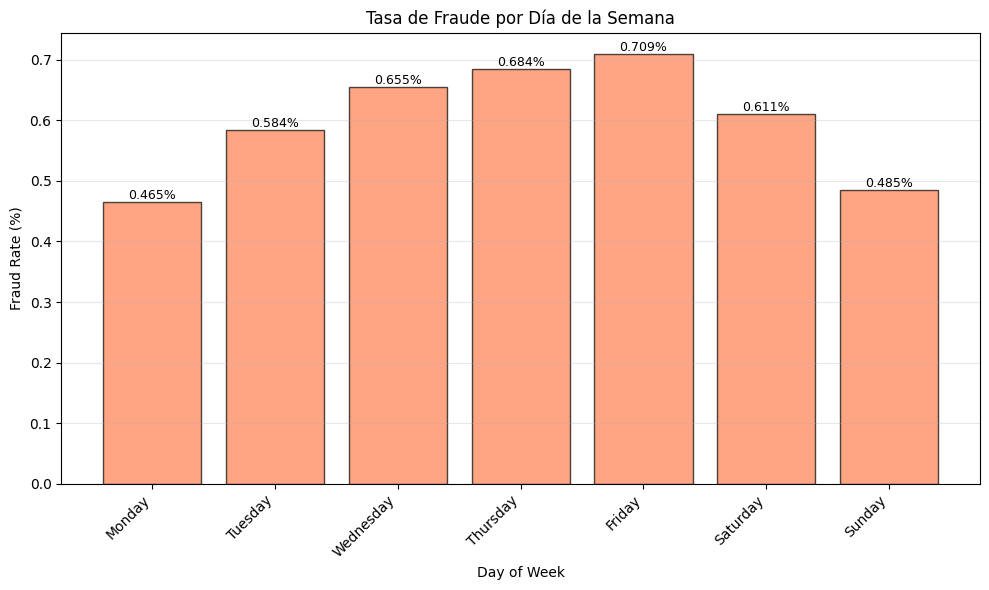


Conclusión:
✓ El día de la semana SÍ es útil como característica.
  El riesgo varía significativamente entre días (hasta 1.52x)


In [6]:
# Calcular la tasa de fraude por día de la semana
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fraud_rate_by_day = []
print("Análisis de Tasa de Fraude por Día de la Semana")
print("=" * 60)

for day in range(7):
    # Total de transacciones del día
    total_day = len(df[df['dayofweek'] == day])
    # Fraudes del día
    fraud_day = len(df[(df['dayofweek'] == day) & (df['is_fraud'] == 1)])
    # Tasa de fraude (%)
    fraud_rate = (fraud_day / total_day * 100) if total_day > 0 else 0
    fraud_rate_by_day.append(fraud_rate)
    
    print(f"{day_names[day]:10} | Total: {total_day:6} | Fraudes: {fraud_day:4} | Tasa: {fraud_rate:.4f}%")

print("\n" + "=" * 60)
print(f"Tasa promedio de fraude: {sum(fraud_rate_by_day)/len(fraud_rate_by_day):.4f}%")
print(f"Tasa mínima: {min(fraud_rate_by_day):.4f}% ({day_names[fraud_rate_by_day.index(min(fraud_rate_by_day))]})")
print(f"Tasa máxima: {max(fraud_rate_by_day):.4f}% ({day_names[fraud_rate_by_day.index(max(fraud_rate_by_day))]})")
print(f"Diferencia: {max(fraud_rate_by_day) - min(fraud_rate_by_day):.4f}%")
print(f"Ratio (max/min): {max(fraud_rate_by_day) / min(fraud_rate_by_day):.2f}x")

# Graficar la tasa de fraude por día
plt.figure(figsize=(10, 6))
bars = plt.bar(range(7), fraud_rate_by_day, edgecolor='black', color='coral', alpha=0.7)
plt.xlabel('Day of Week')
plt.ylabel('Fraud Rate (%)')
plt.title('Tasa de Fraude por Día de la Semana')
plt.xticks(range(7), day_names, rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

# Añadir valores en las barras
for i, (bar, rate) in enumerate(zip(bars, fraud_rate_by_day)):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{rate:.3f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("Conclusión:")
if max(fraud_rate_by_day) / min(fraud_rate_by_day) > 1.5:
    print(f"✓ El día de la semana SÍ es útil como característica.")
    print(f"  El riesgo varía significativamente entre días (hasta {max(fraud_rate_by_day) / min(fraud_rate_by_day):.2f}x)")
else:
    print(f"✗ El día de la semana NO es muy útil como característica.")
    print(f"  El riesgo es similar entre todos los días (variación: {max(fraud_rate_by_day) / min(fraud_rate_by_day):.2f}x)")

fraud transactions mean distance: 0.7673
not fraud transactions mean distance: 0.7657


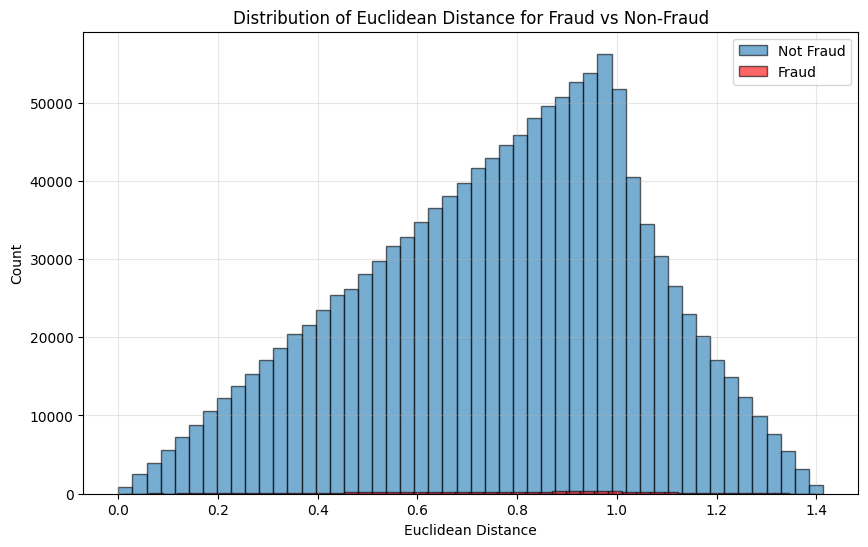

In [7]:
#Analysis of behavior geographical
import numpy as np

lat = df['lat'] 
merch_lat = df['merch_lat']
long = df['long']
merch_long = df['merch_long']

df['dist_euclidean'] = np.sqrt( (merch_lat - lat ) ** 2 
                                + (merch_long - long) ** 2
                                )

print(f'fraud transactions mean distance: {df[df["is_fraud"] == 1]["dist_euclidean"].mean():.4f}')
print(f'not fraud transactions mean distance: {df[df["is_fraud"] == 0]["dist_euclidean"].mean():.4f}')

plt.figure(figsize=(10,6))
plt.hist(df[df['is_fraud'] == 0]['dist_euclidean'], bins=50, alpha=0.6, label='Not Fraud', edgecolor='black')
plt.hist(df[df['is_fraud'] == 1]['dist_euclidean'], bins=50, alpha=0.6, label='Fraud', edgecolor='black', color='red')
plt.legend()
plt.xlabel('Euclidean Distance')
plt.ylabel('Count')
plt.title('Distribution of Euclidean Distance for Fraud vs Non-Fraud')
plt.grid(True, alpha=0.3)
plt.show()


- Fraude: 0.7673
- No Fraude: 0.7657

**Conclusión**: Las medias son prácticamente idénticas. Esto nos dice que, al menos de forma global y lineal, la distancia euclidiana por sí sola no es una "bala de plata" para identificar el fraude en este dataset específico.

In [ ]:
print(df[df['is_fraud'] == 1]['amt'].describe())
print(df[df['is_fraud'] == 0]['amt'].describe())

count    7506.000000
mean      531.320092
std       390.560070
min         1.060000
25%       245.662500
50%       396.505000
75%       900.875000
max      1376.040000
Name: amt, dtype: float64
count    1.289169e+06
mean     6.766711e+01
std      1.540080e+02
min      1.000000e+00
25%      9.610000e+00
50%      4.728000e+01
75%      8.254000e+01
max      2.894890e+04
Name: amt, dtype: float64


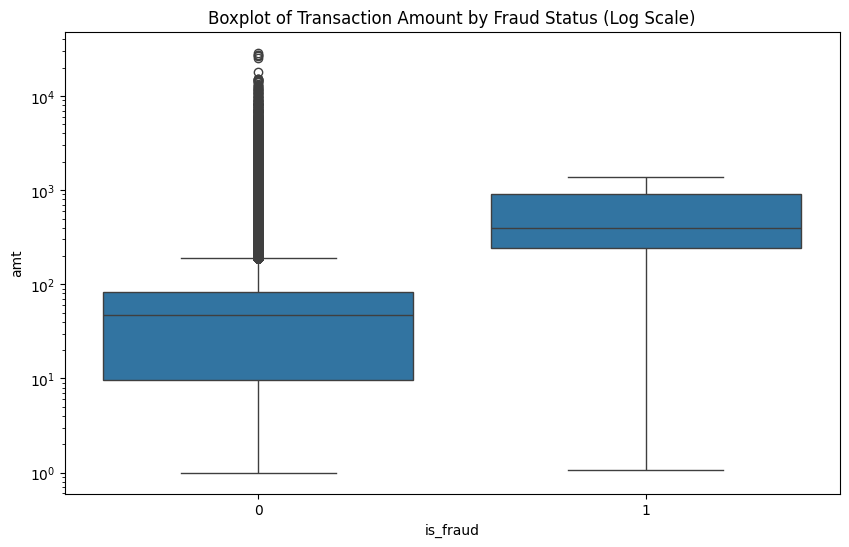

In [9]:
import seaborn as sns

plt.figure(figsize=(10,6))
sns.boxplot(x='is_fraud', y='amt', data=df)
plt.yscale('log')
plt.title('Boxplot of Transaction Amount by Fraud Status (Log Scale)')
plt.show()


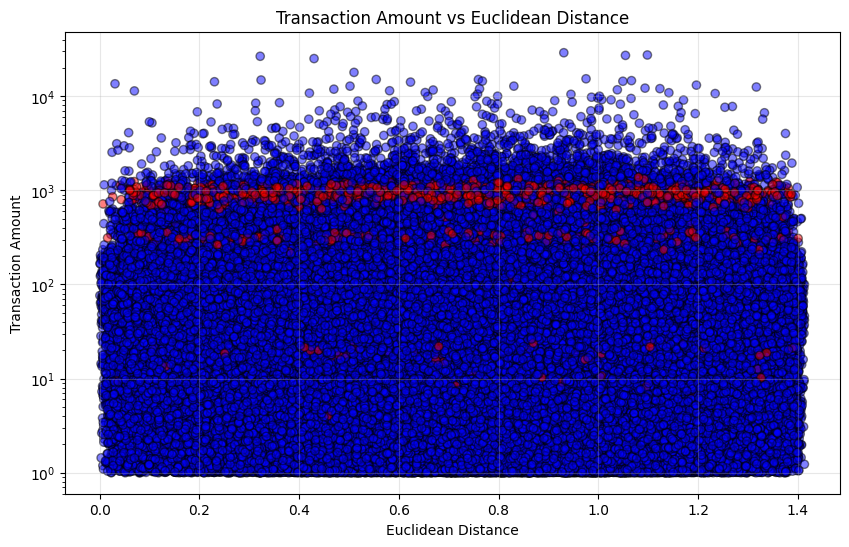

In [17]:
x = df['dist_euclidean']
y = df['amt']
plt.figure(figsize=(10,6))
plt.scatter(x, y, alpha=0.5, edgecolors='black', c=df['is_fraud'].map({0: 'blue', 1: 'red'}))
plt.yscale('log')
plt.xlabel('Euclidean Distance')
plt.ylabel('Transaction Amount')
plt.title('Transaction Amount vs Euclidean Distance')
plt.grid(True, alpha=0.3)
plt.show()

Los puntos rojos no están dispersos por todos lados. Se concentran en una línea horizontal muy marcada entre 102 y 103 en el eje del monto.

Traducción: El fraude en este dataset ocurre casi exclusivamente en transacciones de montos específicos (aproximadamente entre 200 USD y 1000 USD).

Distancia: Como sospechábamos por el histograma, los puntos rojos están repartidos en todo el eje X. Esto confirma que el estafador puede estar cerca o lejos; la distancia no es el factor determinante por sí sola, pero el monto sí lo es.